<a href="https://colab.research.google.com/github/efeecllk/investor-sentiments/blob/main/bitcoin_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install emoji

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import gensim
from sklearn.linear_model import LogisticRegression
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import string
import re
import emoji


In [11]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
# Load Bitcoin Tweet Dataset
tweets_df = pd.read_csv('/content/drive/MyDrive/NLP/Bitcoin_tweets.csv', nrows=10000)

# Load Bitcoin Price Dataset
price_df = pd.read_csv('/content/drive/MyDrive/NLP/bitcoin_2017_to_2023.csv')



In [ ]:
tweets_df.head()


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


In [13]:
price_df.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.68658,1.354538e+05,258,0.89391,25836.224836
1,2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.77589,1.380351e+05,317,2.24546,64899.385195
2,2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.52263,3.330532e+05,451,2.70873,78290.170121
3,2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.89610,4.595556e+05,483,10.22981,295738.166916
4,2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.74657,1.090761e+06,686,16.50452,476955.246611


In [17]:
import pandas as pd

# Convert dates and times
tweets_df['user_created'] = pd.to_datetime(tweets_df['user_created'], errors='coerce')
price_df['timestamp'] = pd.to_datetime(price_df['timestamp'], errors='coerce')

# Clean invalid values and sort by time
tweets_df = tweets_df.dropna(subset=['user_created']).sort_values(by='user_created')
price_df = price_df.dropna(subset=['timestamp']).sort_values(by='timestamp')

# Match timestamps while preserving all tweets
merged_df = pd.merge_asof(
    tweets_df,
    price_df,
    left_on='user_created',
    right_on='timestamp',
    direction='backward',
    tolerance=pd.Timedelta('1d')  # Maximum 1-day difference
)

# Calculate time difference (optional)
merged_df['time_difference'] = (merged_df['user_created'] - merged_df['timestamp']).abs()

# Check for unmatched rows
missing_matches = merged_df[merged_df['timestamp'].isna()]
print(f"Number of Unmatched Tweets: {len(missing_matches)}")

# Perform forward search for unmatched tweets
merged_df_forward = pd.merge_asof(
    tweets_df,
    price_df,
    left_on='user_created',
    right_on='timestamp',
    direction='forward',
    tolerance=pd.Timedelta('1d')
)

# Combine and remove duplicates
final_merged_df = pd.concat([merged_df, merged_df_forward]).drop_duplicates(subset=['user_created'])

# Check still unmatched rows
still_missing = final_merged_df[final_merged_df['timestamp'].isna()]
print(f"Number of Still Unmatched Tweets: {len(still_missing)}")

# Display results
print("\nMatched Tweet and Price Data:")
print(final_merged_df.head())

# Remove unmatched records (rows where 'timestamp' is NaN)
final_merged_df = final_merged_df.dropna(subset=['timestamp']).reset_index(drop=True)

# Verify the final dataset
print(f"Number of Unmatched Tweets After Removal: {final_merged_df['timestamp'].isna().sum()}")
print("\nMatched Tweet and Price Data (Unmatched Removed):")
print(final_merged_df.head())


Number of Unmatched Tweets: 3969
Number of Still Unmatched Tweets: 1802

Matched Tweet and Price Data:
        user_name         user_location  \
0       Greg Kidd       Crystal Bay, NV   
1     Yaron Samid              Tel Aviv   
2  Travis Russell                   NaN   
3   ngc_3370 LION       ngc_3370 Galaxy   
4  Justin Roberti  Nonspecificville, PA   

                                    user_description        user_created  \
0  CEO GlobaliD (@myglobal_id), co-founder Hard Y... 2006-04-01 03:32:37   
1  3X dad, 3X founder, investor and community bui... 2006-12-04 19:48:28   
2  #Bitcoin | Aquaponics | Padres | https://t.co/... 2007-01-26 19:40:36   
3  “As soon as you stop wanting or dreaming somet... 2007-03-12 07:41:16   
4  Writer & podcast producer - Games, tech, finte... 2007-04-03 01:57:06   

   user_followers  user_friends  user_favourites  user_verified  \
0         12868.0           132              417          False   
1          4792.0           140             124

In [18]:
# Remove unmatched records (rows where 'timestamp' is NaN)
final_merged_df = final_merged_df.dropna(subset=['timestamp']).reset_index(drop=True)
merged_df = final_merged_df

In [19]:
merged_df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,...,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,time_difference
0,Michael Arouet,Somewhere in Europe,"Independent investor, correlation deviations b...",2017-08-17 11:22:22,795.0,482,1530,False,2021-02-09 22:34:39,"#Bitcoin unrealized losses must be recognized,...",...,4474.80,4474.80,4474.80,4474.80,0.000000,0.000000,0.0,0.000000,0.000000,0 days 00:00:22
1,athcrypt℗,Croatia,MIT / UX & Product Designer / $BTC $ETH $DOGE ...,2017-08-18 09:29:07,413.0,396,23026,False,2021-02-09 07:20:41,Hacked with nudes #blockfolio @blockfolio #btc...,...,4321.20,4327.25,4307.01,4307.01,0.369231,1595.893279,7.0,0.086659,374.904408,0 days 00:00:07
2,Wickhunterr,India,Pure Technical Analyst 🔥\nTrading Crypto since...,2017-08-18 14:19:50,80.0,167,1356,False,2021-02-10 00:05:25,The So called Next BTC is waking up\n\n#YFI #D...,...,4272.92,4272.92,4272.92,4272.92,0.107711,460.240486,1.0,0.107711,460.240486,0 days 00:00:50
3,Kayth,Europe,Software Engineer. #Bitcoin only.,2017-08-18 16:40:28,40.0,428,1628,False,2021-02-08 19:07:28,If you want to create a bitcoin seed with dice...,...,4266.72,4266.72,4266.72,4266.72,0.060301,257.287483,1.0,0.060301,257.287483,0 days 00:00:28
4,The 1 i Am Neo,"Los Angeles, CA",Bitcoin Trader,2017-08-18 17:36:59,142.0,95,3,False,2021-02-08 16:37:20,#Bitcoin #BTC #btcusd $btc https://t.co/lAMPlm...,...,4126.45,4126.45,4126.45,4126.45,0.000000,0.000000,0.0,0.000000,0.000000,0 days 00:00:59


In [ ]:
merged_df = merged_df.drop('user_location', axis=1)

In [ ]:
merged_df.columns

In [ ]:
merged_df.shape[0]

## Preprocess

In [23]:
def preprocess_text(text):
    text = emoji.demojize(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])
    return text



In [20]:
len(merged_df)

2415

In [24]:
merged_df['text'] = merged_df['text'].apply(preprocess_text)


In [22]:
merged_df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,...,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,time_difference
0,Michael Arouet,Somewhere in Europe,"Independent investor, correlation deviations b...",2017-08-17 11:22:22,795.0,482,1530,False,2021-02-09 22:34:39,"#Bitcoin unrealized losses must be recognized,...",...,4474.80,4474.80,4474.80,4474.80,0.000000,0.000000,0.0,0.000000,0.000000,0 days 00:00:22
1,athcrypt℗,Croatia,MIT / UX & Product Designer / $BTC $ETH $DOGE ...,2017-08-18 09:29:07,413.0,396,23026,False,2021-02-09 07:20:41,Hacked with nudes #blockfolio @blockfolio #btc...,...,4321.20,4327.25,4307.01,4307.01,0.369231,1595.893279,7.0,0.086659,374.904408,0 days 00:00:07
2,Wickhunterr,India,Pure Technical Analyst 🔥\nTrading Crypto since...,2017-08-18 14:19:50,80.0,167,1356,False,2021-02-10 00:05:25,The So called Next BTC is waking up\n\n#YFI #D...,...,4272.92,4272.92,4272.92,4272.92,0.107711,460.240486,1.0,0.107711,460.240486,0 days 00:00:50
3,Kayth,Europe,Software Engineer. #Bitcoin only.,2017-08-18 16:40:28,40.0,428,1628,False,2021-02-08 19:07:28,If you want to create a bitcoin seed with dice...,...,4266.72,4266.72,4266.72,4266.72,0.060301,257.287483,1.0,0.060301,257.287483,0 days 00:00:28
4,The 1 i Am Neo,"Los Angeles, CA",Bitcoin Trader,2017-08-18 17:36:59,142.0,95,3,False,2021-02-08 16:37:20,#Bitcoin #BTC #btcusd $btc https://t.co/lAMPlm...,...,4126.45,4126.45,4126.45,4126.45,0.000000,0.000000,0.0,0.000000,0.000000,0 days 00:00:59


In [25]:
import gensim
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pickle


## Word2Vec

In [26]:
# Word2Vec modelini yükle
word2vec_model = gensim.models.Word2Vec.load('/content/drive/MyDrive/NLP/word2vec_model.model')


In [27]:
# Rastgele bir kelimenin vektörünü kontrol edin
print(word2vec_model.wv['good'] if 'good' in word2vec_model.wv else "Kelime bulunamadı")


[ 1.2065066  -1.5498743   4.3290806   1.0235827  -2.1191995  -1.91932
 -2.627178   -2.0179203   2.7778153   0.6003324  -1.7520316  -1.2726218
 -0.38420677  0.4580238  -0.74335617  2.7906876  -1.2787054   4.1497583
 -4.2355137  -0.0926513   2.2251964  -3.625772   -4.4894533  -1.553813
  1.0811808   2.416639   -0.82610786 -3.0229242  -2.5270538   1.2096163
 -2.809983   -1.0944238   0.86705756 -0.3064526   3.830741   -0.86024964
  0.6256468   2.1056542   1.5155813  -1.5912137  -1.600227   -2.2993665
  2.0102804   0.43171695  0.0521418   0.7106995  -1.5751389   2.0218503
  1.6405704   0.79498047  0.5910279  -1.612377    3.2804937   0.7853499
 -0.21600401 -3.304779   -0.56850135 -0.5327709   0.19682382  1.2346387
 -0.6314158   2.6147592   0.31772268  1.0094956   1.1704543  -0.82502985
 -3.0374503  -2.0160258   0.9556052   2.9681206   1.0318193   2.0981019
 -1.7339318  -2.8082595   1.6445243   0.28596678 -0.31484386 -0.9602643
 -2.755997   -6.159275   -0.16718331 -1.1541643  -0.9273664   0.2

## Logistic Regression

In [28]:
import joblib
logistic_model = joblib.load('/content/drive/MyDrive/NLP/llogistic_model.pkl')
def sentiment_analysis(text):
    vector = text_to_word2vec(text, word2vec_model)
    sentiment = logistic_model.predict([vector])[0]
    return sentiment


In [29]:
def text_to_word2vec(text, model):
    words = text.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [30]:

merged_df['sentiment_label'] = merged_df['text'].apply(lambda x: sentiment_analysis(x))

# Display sample rows with sentiment labels
print("\nDataset with Sentiment Labels:")
print(merged_df[['text', 'sentiment_label']].head())



Dataset with Sentiment Labels:
                                                text  sentiment_label
0  bitcoin unrealized loss must recognized unreal...                2
1  hacked nude blockfolio blockfolio btc bitcoin ...                0
2  called next btc waking yfi defi btc binance bi...                1
3  want create bitcoin seed dice roll time roll d...                1
4  bitcoin btc btcusd btc httpstcolamplmodt live ...                0


## Neural Network

In [31]:
import tensorflow as tf

nn_model = tf.keras.models.load_model('/content/drive/MyDrive/NLP/sentiment_nn_model.h5')


In [32]:
# Sentiment Mapping (0: Neutral, 1: Bullish, 2: Bearish)
sentiment_mapping = {0: 'Neutral', 1: 'Bullish', 2: 'Bearish'}

# Sentiment Prediction Function
def nn_sentiment_analysis(text):
    vector = text_to_word2vec(text, word2vec_model)
    vector = np.expand_dims(vector, axis=0)  # Reshape for NN input
    prediction = nn_model.predict(vector, verbose=0)
    sentiment = np.argmax(prediction)
    confidence = round(np.max(prediction), 2)
    return sentiment, confidence

# Apply NN Sentiment Analysis to Dataset
merged_df['sentiment_label_nn'], merged_df['confidence_score_nn'] = zip(
    *merged_df['text'].apply(lambda x: nn_sentiment_analysis(x))
)

# Map Numeric Labels to Text
merged_df['sentiment_label_text_nn'] = merged_df['sentiment_label_nn'].map(sentiment_mapping)

# Display Sample Rows
print(merged_df[['text', 'sentiment_label_nn', 'sentiment_label_text_nn', 'confidence_score_nn']].head())

                                                text  sentiment_label_nn  \
0  bitcoin unrealized loss must recognized unreal...                   2   
1  hacked nude blockfolio blockfolio btc bitcoin ...                   0   
2  called next btc waking yfi defi btc binance bi...                   1   
3  want create bitcoin seed dice roll time roll d...                   1   
4  bitcoin btc btcusd btc httpstcolamplmodt live ...                   0   

  sentiment_label_text_nn  confidence_score_nn  
0                 Bearish                 1.00  
1                 Neutral                 0.61  
2                 Bullish                 0.74  
3                 Bullish                 1.00  
4                 Neutral                 0.93  


In [ ]:
merged_df.columns

In [33]:

# Define the mapping dictionary
label_mapping = {0: 'Neutral', 1: 'Bullish', 2: 'Bearish'}

# Apply mapping to the 'label' column
merged_df['sentiment_label_name'] = merged_df['sentiment_label'].map(label_mapping)

# Verify if mapping was successful
print(merged_df[['sentiment_label', 'sentiment_label_name']].head())


   sentiment_label sentiment_label_name
0                2              Bearish
1                0              Neutral
2                1              Bullish
3                1              Bullish
4                0              Neutral


## Sentiment Label Distributions

sentiment_label_name
Bullish    1220
Neutral     642
Bearish     553
Name: count, dtype: int64


<ipython-input-34-7fb80d3e3e51>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='sentiment_label_name', palette='viridis')


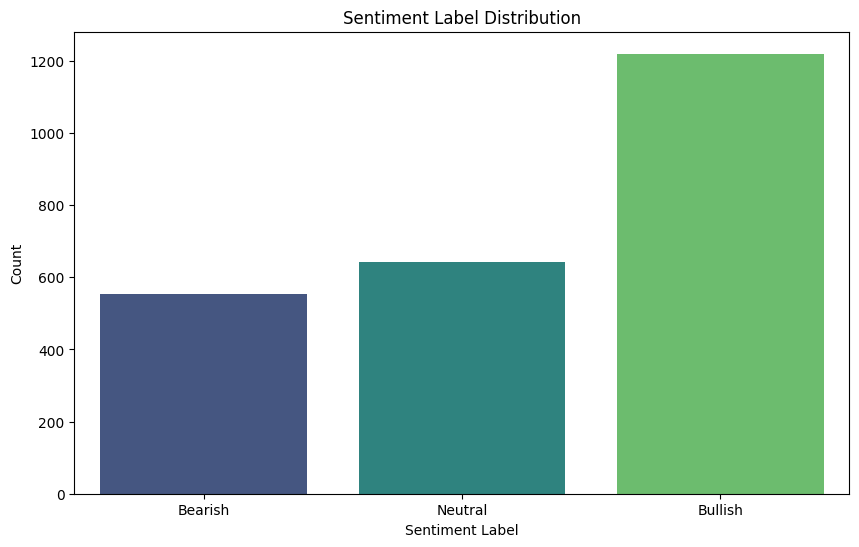

In [34]:
# Cell 3: Sentiment Label Distribution

import seaborn as sns
import matplotlib.pyplot as plt

# Display distribution
print(merged_df['sentiment_label_name'].value_counts())

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='sentiment_label_name', palette='viridis')
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()


sentiment_label_text_nn
Bullish    1400
Neutral     642
Bearish     373
Name: count, dtype: int64


<ipython-input-35-179dd263faa5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='sentiment_label_text_nn', palette='viridis')


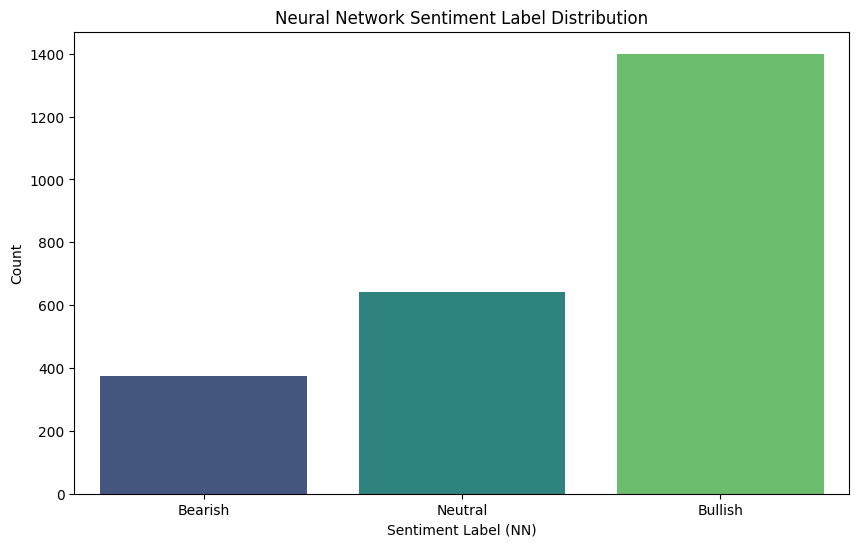

In [35]:
# Cell: Neural Network Sentiment Label Distribution

import seaborn as sns
import matplotlib.pyplot as plt

# Display distribution of NN sentiment labels
print(merged_df['sentiment_label_text_nn'].value_counts())

# Plot sentiment distribution for NN labels
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='sentiment_label_text_nn', palette='viridis')
plt.title('Neural Network Sentiment Label Distribution')
plt.xlabel('Sentiment Label (NN)')
plt.ylabel('Count')
plt.show()


## User Influence Score

In [36]:
# Influence Score hesaplama
merged_df['user_verified_score'] = merged_df['user_verified'].apply(lambda x: 2 if x else 1)
merged_df['is_retweet_score'] = merged_df['is_retweet'].apply(lambda x: 1 if x else 0)
# merged_df['user_followers'] = np.log1p(merged_df['user_followers'])

# Ağırlıklandırılmış Etki Skoru
merged_df['influence_score'] = (
    0.5 * merged_df['user_followers'] +
    0.1 * merged_df['user_favourites'] +
    0.2 * merged_df['is_retweet_score'] +
    0.2 * merged_df['user_verified_score']
)


In [37]:
merged_df['is_retweet']

,is_retweet
0,False
1,False
2,False
3,False
4,False
...,...
2410,False
2411,False
2412,False
2413,False


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119813 (\N{MATHEMATICAL BOLD CAPITAL F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119842 (\N{MATHEMATICAL BOLD SMALL I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119847 (\N{MATHEMATICAL BOLD SMALL N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119834 (\N{MATHEMATICAL BOLD SMALL A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119859 (\N{MATHEMATICAL BOLD SMALL Z}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/us

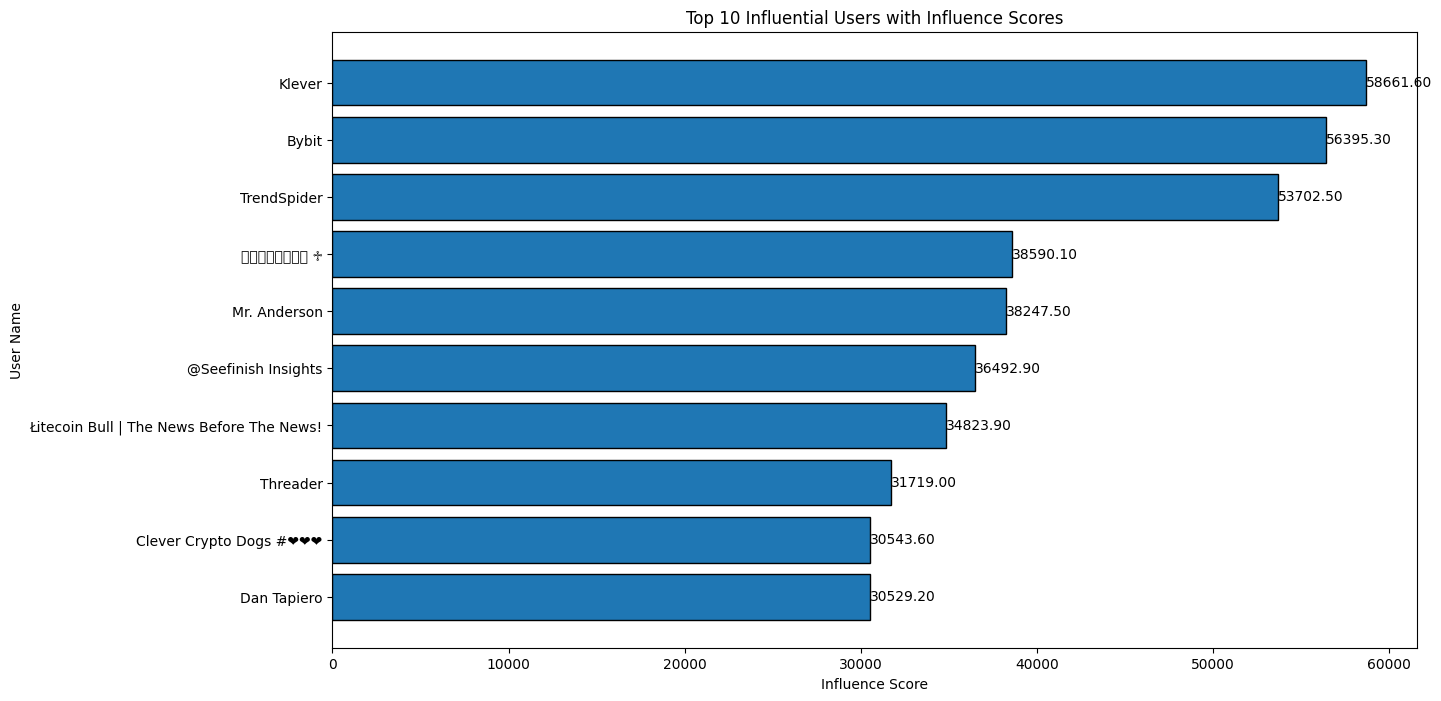

In [38]:
import matplotlib.pyplot as plt

# En etkili 10 kullanıcıyı seçme
top_influencers = merged_df.nlargest(10, 'influence_score')[['user_name', 'influence_score']]

# Grafik oluşturma
plt.figure(figsize=(14, 8))
bars = plt.barh(
    top_influencers['user_name'],
    top_influencers['influence_score'],
    edgecolor='black'
)

# Her bar'ın üzerine puanı yazdırma
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height()/2,
        f'{bar.get_width():.2f}',
        va='center'
    )

plt.title('Top 10 Influential Users with Influence Scores')
plt.xlabel('Influence Score')
plt.ylabel('User Name')
plt.gca().invert_yaxis()  # En yüksek skoru en üstte gösterir
plt.show()


### BTC PRICE GUESS

In [39]:
# Fiyat Değişimini Belirleme
merged_df['price_trend'] = merged_df.apply(
    lambda row: 'up' if row['close'] > row['open'] else ('down' if row['close'] < row['open'] else 'neutral'),
    axis=1
)


In [40]:
# Kullanıcının Tahmin Doğruluğu
def check_prediction(row):
    if row['sentiment_label'] == 1 and row['price_trend'] == 'up':
        return 'correct'
    elif row['sentiment_label'] == 2 and row['price_trend'] == 'down':
        return 'correct'
    elif row['sentiment_label'] == 0 and row['price_trend'] == 'neutral':
        return 'correct'
    else:
        return 'wrong'

merged_df['prediction_accuracy'] = merged_df.apply(check_prediction, axis=1)


prediction_accuracy_nn
wrong      1543
correct     872
Name: count, dtype: int64


<ipython-input-41-078932c41661>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='prediction_accuracy_nn', palette='viridis')


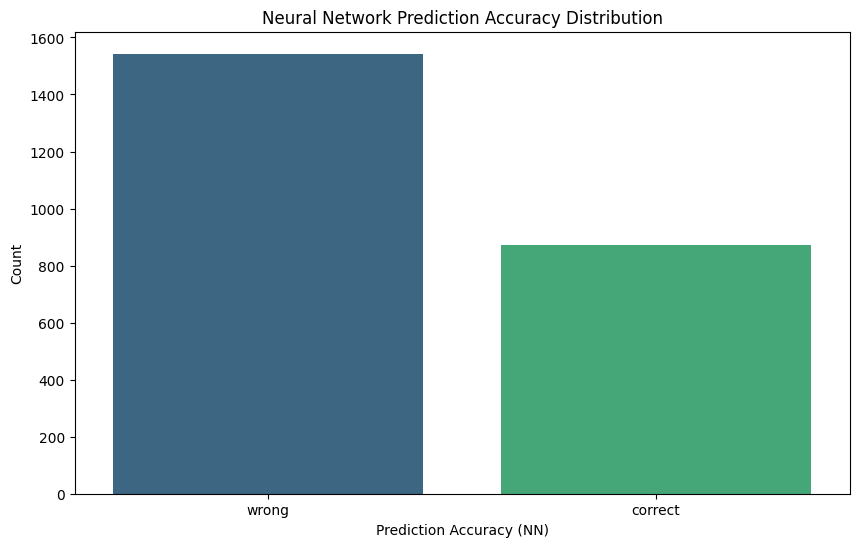

In [41]:
# Cell: Neural Network Prediction Accuracy

# Kullanıcının Neural Network Tahmin Doğruluğu Kontrol Fonksiyonu
def check_prediction_nn(row):
    if row['sentiment_label_nn'] == 1 and row['price_trend'] == 'up':
        return 'correct'
    elif row['sentiment_label_nn'] == 2 and row['price_trend'] == 'down':
        return 'correct'
    elif row['sentiment_label_nn'] == 0 and row['price_trend'] == 'neutral':
        return 'correct'
    else:
        return 'wrong'

# Neural Network doğruluğu hesapla
merged_df['prediction_accuracy_nn'] = merged_df.apply(check_prediction_nn, axis=1)

# Doğruluk dağılımını görüntüle
print(merged_df['prediction_accuracy_nn'].value_counts())

# Görselleştir
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='prediction_accuracy_nn', palette='viridis')
plt.title('Neural Network Prediction Accuracy Distribution')
plt.xlabel('Prediction Accuracy (NN)')
plt.ylabel('Count')
plt.show()


In [42]:
# Tahminlerin Sayısını Hesaplama
prediction_counts = merged_df['prediction_accuracy'].value_counts().reset_index()
prediction_counts.columns = ['Prediction Accuracy', 'Count']

# Sonuçları Görüntüleme
print(prediction_counts)


  Prediction Accuracy  Count
0               wrong   1528
1             correct    887


In [43]:
# Cell: Neural Network Prediction Accuracy Counts

# Neural Network Tahminlerinin Sayısını Hesapla
prediction_counts_nn = merged_df['prediction_accuracy_nn'].value_counts().reset_index()
prediction_counts_nn.columns = ['Prediction Accuracy (NN)', 'Count']

# Sonuçları Görüntüle
print("\nNeural Network Prediction Accuracy Counts:")
print(prediction_counts_nn)



Neural Network Prediction Accuracy Counts:
  Prediction Accuracy (NN)  Count
0                    wrong   1543
1                  correct    872


In [44]:
# Correct ve Wrong Tahminler için Influence Score Ortalaması
correct_avg_influence = merged_df[merged_df['prediction_accuracy'] == 'correct']['influence_score'].mean()
wrong_avg_influence = merged_df[merged_df['prediction_accuracy'] == 'wrong']['influence_score'].mean()

# Sonuçları Yazdır
print(f"Correct Tahminlerin Ortalama Influence Score'u: {correct_avg_influence:.2f}")
print(f"Wrong Tahminlerin Ortalama Influence Score'u: {wrong_avg_influence:.2f}")


Correct Tahminlerin Ortalama Influence Score'u: 1065.81
Wrong Tahminlerin Ortalama Influence Score'u: 973.32


In [45]:
merged_df.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet', 'timestamp', 'open',
       'high', 'low', 'close', 'volume', 'quote_asset_volume',
       'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'time_difference', 'sentiment_label',
       'sentiment_label_nn', 'confidence_score_nn', 'sentiment_label_text_nn',
       'sentiment_label_name', 'user_verified_score', 'is_retweet_score',
       'influence_score', 'price_trend', 'prediction_accuracy',
       'prediction_accuracy_nn'],
      dtype='object')

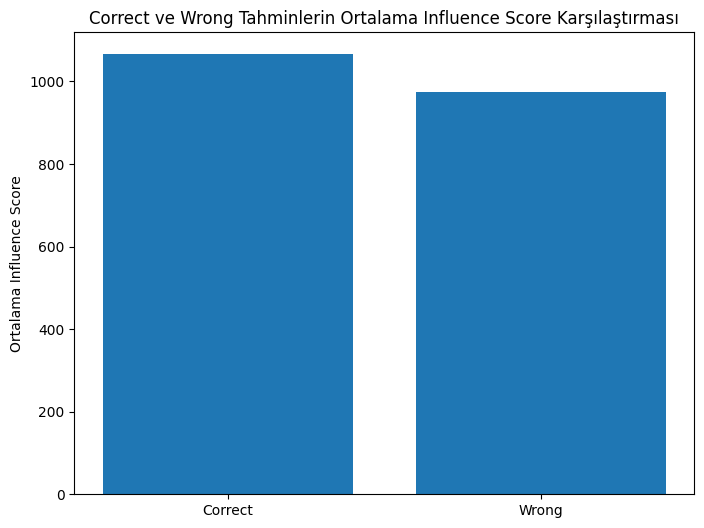

In [46]:
import matplotlib.pyplot as plt

# Veriyi Hazırlama
avg_scores = {
    'Correct': correct_avg_influence,
    'Wrong': wrong_avg_influence
}

# Bar Grafiği
plt.figure(figsize=(8, 6))
plt.bar(avg_scores.keys(), avg_scores.values())
plt.title('Correct ve Wrong Tahminlerin Ortalama Influence Score Karşılaştırması')
plt.ylabel('Ortalama Influence Score')
plt.show()


## **Extra(This part is not part of the project)**

## LSTM FOR BTC

In [53]:
# Rastgele 10,000 satır seç
price_df_subset = price_df.sample(n=100000, random_state=42).sort_index()


In [54]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Fiyatı ölçeklendir
scaler = MinMaxScaler()
price_df_subset['scaled_close'] = scaler.fit_transform(price_df_subset[['close']])

# Eğitim ve test veri setlerini ayır
train_size = int(len(price_df_subset) * 0.8)
train, test = price_df_subset[:train_size], price_df_subset[train_size:]

# LSTM için veri hazırlama
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(train['scaled_close'].values, seq_length)
X_test, y_test = create_sequences(test['scaled_close'].values, seq_length)

# LSTM için veri şekillendirme
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Model Oluştur
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

# Modeli Derle
model.compile(optimizer='adam', loss='mean_squared_error')

# Modeli Eğit
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0054 - val_loss: 8.9265e-06
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 2.0293e-05 - val_loss: 1.8974e-06
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 1.9221e-05 - val_loss: 3.2714e-07
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 1.6189e-05 - val_loss: 3.4364e-07
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 1.4679e-05 - val_loss: 5.6971e-07
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 1.3365e-05 - val_loss: 5.8099e-07
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 1.1670e-05 - val_loss: 6.2053e-07
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 1.0800e-05 - val_loss: 8.4923e-07
Epoch 9/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 1.1303e-05 - val_loss: 4.8218e-06
Epoch 10/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 1.0647e-05 - val_loss: 1.8033e-06


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


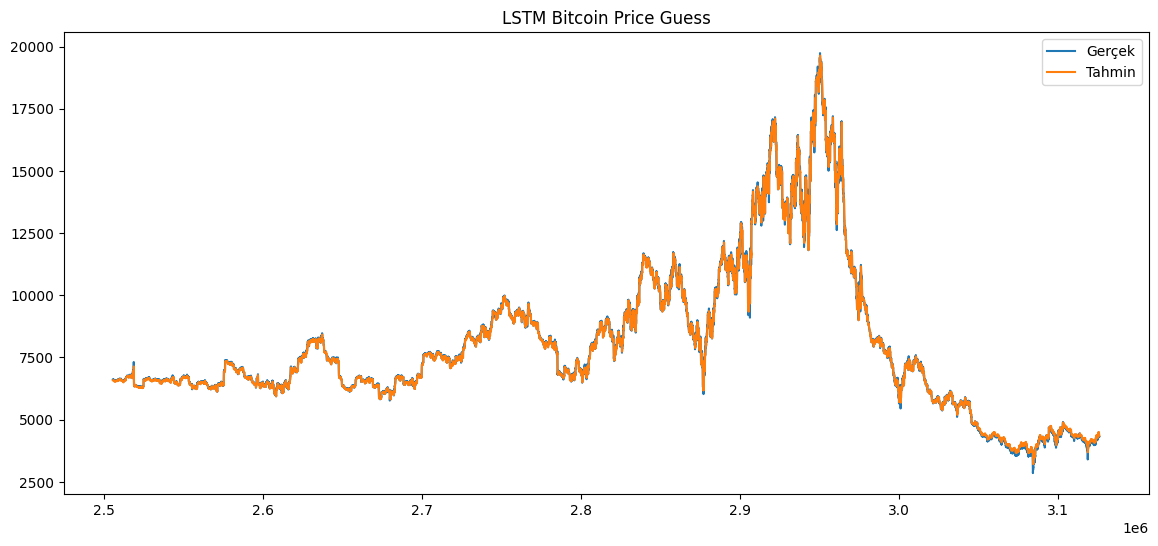

In [57]:
# Test veri setinde tahmin yap
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

import matplotlib.pyplot as plt

# Gerçek ve tahmin edilen değerleri görselleştir
plt.figure(figsize=(14, 6))
plt.plot(test.index[seq_length:], scaler.inverse_transform(test['scaled_close'][seq_length:].values.reshape(-1, 1)), label='Gerçek')
plt.plot(test.index[seq_length:], predictions, label='Tahmin')
plt.legend()
plt.title('LSTM Bitcoin Price Guess')
plt.show()
